In [1]:
import re
import numpy as np
import pandas as pd
import langdetect
from tqdm import tqdm
from nltk.corpus import stopwords
from langdetect import detect
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xuenichen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/xuenichen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xuenichen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
autism_file_path = '/Users/xuenichen/Desktop/BEF_Chen/dataset/Twitter Autism/autism.csv'
control_file_path = '/Users/xuenichen/Desktop/BEF_Chen/dataset/Twitter Autism/control_group.csv'

# Load the datasets
autism_df = pd.read_csv(autism_file_path)
control_df = pd.read_csv(control_file_path)

In [4]:
# Check for missing values in all columns
missing_values = autism_df.isnull().sum()
print("Missing values per column:\n", missing_values)

total_rows = autism_df.shape[0]
print("Total number of rows:", total_rows)

Missing values per column:
 User_ID                      0
Profile description         33
Account created              0
Friends count                0
Followers count              0
Tweet date                   0
Tweet id                     0
Language                     0
Tweet text                   1
Hashtags               2161360
Location                552315
Reply count                  0
Retweet count                0
Like count                   0
Source                       0
dtype: int64
Total number of rows: 3137952


In [5]:
# Check for missing values in all columns
missing_values = control_df.isnull().sum()
print("Missing values per column:\n", missing_values)

total_rows = control_df.shape[0]
print("Total number of rows:", total_rows)

Missing values per column:
 User_ID                      0
Profile description     477327
Account created              0
Friends count                0
Followers count              0
Tweet date                   0
Tweet id                     0
Language                     0
Tweet text                  14
Hashtags               3020503
Location               1073027
Reply count                  0
Retweet count                0
Like count                   0
Source                       0
dtype: int64
Total number of rows: 3377518


# drop some columns and rows

In [6]:
# Drop rows where 'User_ID' is NaN in autism_df
autism_df = autism_df.dropna(subset=['User_ID'])

# Drop rows where 'User_ID' is NaN in control_df
control_df = control_df.dropna(subset=['User_ID'])

In [7]:
control_df = control_df.drop(columns=['Source', 'Account created',])
autism_df = autism_df.drop(columns=['Source', 'Account created',])
autism_df.head()
control_df.head()

,User_ID,Profile description,Friends count,Followers count,Tweet date,Tweet id,Language,Tweet text,Hashtags,Location,Reply count,Retweet count,Like count
0,b0b63865cbb84efcd5422e42d13c8672707c82185c2cdf...,🏈🥋✈️🌎,115,1175,2020-12-31 23:59:58+00:00,1344795463317389312,en,"People come and go, yet they remain irreplacea...",NaN,NaN,0,0,0
1,978a4548ee471aa84938dd67052799fa586d45fe405517...,Official Dorset Live Weather twitter page. Liv...,2955,3053,2016-03-05 23:59:54+00:00,706268029634613248,en,"Wind 1.2 mph WNW. Barometer 1013.4 hPa, Rising...",NaN,"Dorset, England",0,0,0
2,5fbafd883c78ace9e30bccaa0caa350e797c625579aeba...,If its meant to be it will happen no matter wh...,207,9938,2014-08-12 23:59:55+00:00,499344560506433536,en,☆*:｡*:*｡:*☆\nluke hemmings &amp; michael cliff...,NaN,NaN,0,1,0
3,b8554e9a8fcc0eaf7485bfeb3ecc0d64373982d33f1660...,"Welcome to my darkness, I've been here awhile.",113,195,2021-03-04 23:59:53+00:00,1367625880030257155,en,I have a mud mask on and my Face ID won’t work 😂,NaN,NaN,0,0,0
4,979462d73dec55949483575709190ed03c0e9b79bbc7f6...,don't you know who i think i am\n\nestudios de...,605,4912,2019-03-30 23:59:35+00:00,1112142359138050048,ht,voy a dormir 3h ****,NaN,icon @hanavbara,0,0,1


## drop rows with no value for 'reply count'& 'retweet cont'
## drop rows with no value for 'friend count'& 'follower cont'

In [8]:
# Filter out rows where 'Reply count', 'Retweet count' are all 0
control_df = control_df[((control_df['Reply count'].notna() & control_df['Reply count'] != 0) |
                         (control_df['Retweet count'].notna() & control_df['Retweet count'] != 0))]

# Filter out rows where 'Friends count', 'Followers count' are both 0
control_df = control_df[((control_df['Friends count'].notna() & control_df['Friends count'] != 0) |
                         (control_df['Followers count'].notna() & control_df['Followers count'] != 0))]

In [9]:
# Filter out rows where 'Reply count', 'Retweet count' are all 0
autism_df = autism_df[((autism_df['Reply count'].notna() & autism_df['Reply count'] != 0) |
                       (autism_df['Retweet count'].notna() & autism_df['Retweet count'] != 0))]

# Filter out rows where 'Friends count', 'Followers count' are both 0
autism_df = autism_df[((autism_df['Friends count'].notna() & autism_df['Friends count'] != 0) |
                       (autism_df['Followers count'].notna() & autism_df['Followers count'] != 0))]

In [10]:
# Remove duplicates based on 'Tweet text'
autism_df = autism_df.drop_duplicates(subset=['Tweet text'])
control_df = control_df.drop_duplicates(subset=['Tweet text'])

In [11]:
print("New total number of rows:", autism_df.shape[0])
print("New total number of rows:", control_df.shape[0])

New total number of rows: 784178
New total number of rows: 525815


## drop rows that has no 'Hashtags'

In [12]:
# Drop rows that have missing values in the 'Hashtags' column
control_df = control_df.dropna(subset=['Hashtags']).copy()
autism_df = autism_df.dropna(subset=['Hashtags']).copy()

In [13]:
print("New total number of rows:", control_df.shape[0])
print("New total number of rows:", autism_df.shape[0])

New total number of rows: 60439
New total number of rows: 265817


## drop rows for non-English

In [14]:
control_df_ratio = control_df['Language'].value_counts(normalize=True)
print("Language ratio before dropping non-English rows:\n", control_df_ratio)

Language ratio before dropping non-English rows:
 Language
en     0.990271
es     0.002813
tl     0.002383
fr     0.001241
pt     0.000811
in     0.000529
nl     0.000414
de     0.000265
eu     0.000232
it     0.000199
sv     0.000149
ht     0.000149
tr     0.000116
et     0.000083
ca     0.000083
da     0.000083
no     0.000066
cy     0.000033
pl     0.000033
lt     0.000017
vi     0.000017
und    0.000017
Name: proportion, dtype: float64


In [15]:
autism_df_ratio = autism_df['Language'].value_counts(normalize=True)
print("Language ratio before dropping non-English rows:\n", autism_df_ratio)

Language ratio before dropping non-English rows:
 Language
en    0.998123
fr    0.000974
de    0.000199
nl    0.000139
tl    0.000109
es    0.000075
ht    0.000056
et    0.000053
tr    0.000038
pt    0.000038
in    0.000038
no    0.000030
it    0.000026
da    0.000023
sv    0.000019
ca    0.000015
vi    0.000011
hi    0.000008
lv    0.000008
eu    0.000008
cy    0.000004
pl    0.000004
is    0.000004
Name: proportion, dtype: float64


In [16]:
control_df = control_df[control_df['Language'] == 'en']
autism_df = autism_df[autism_df['Language'] == 'en']

In [17]:
control_df_ratio = control_df['Language'].value_counts(normalize=True)
print("Language ratio after dropping non-English rows:\n", control_df_ratio)

Language ratio after dropping non-English rows:
 Language
en    1.0
Name: proportion, dtype: float64


In [18]:
autism_df_ratio = autism_df['Language'].value_counts(normalize=True)
print("Language ratio after dropping non-English rows:\n", autism_df_ratio)

Language ratio after dropping non-English rows:
 Language
en    1.0
Name: proportion, dtype: float64


In [19]:
# Check for missing values in all columns
missing_values = control_df.isnull().sum()
print("Missing values per column:\n", missing_values)

total_rows = control_df.shape[0]
print("Total number of rows:", total_rows)

Missing values per column:
 User_ID                    0
Profile description     5221
Friends count              0
Followers count            0
Tweet date                 0
Tweet id                   0
Language                   0
Tweet text                 0
Hashtags                   0
Location               15257
Reply count                0
Retweet count              0
Like count                 0
dtype: int64
Total number of rows: 59851


In [20]:
# Check for missing values in all columns
missing_values = autism_df.isnull().sum()
print("Missing values per column:\n", missing_values)

total_rows = autism_df.shape[0]
print("Total number of rows:", total_rows)

Missing values per column:
 User_ID                    0
Profile description        0
Friends count              0
Followers count            0
Tweet date                 0
Tweet id                   0
Language                   0
Tweet text                 0
Hashtags                   0
Location               47242
Reply count                0
Retweet count              0
Like count                 0
dtype: int64
Total number of rows: 265318


In [21]:
print("New total number of rows:", control_df.shape[0])
print("New total number of rows:", autism_df.shape[0])

New total number of rows: 59851
New total number of rows: 265318


# clean the tweet texts

In [22]:
# Function to clean tweet text
def clean_tweet_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#', '', text)
    # Remove HTML entities
    text = re.sub(r'&[a-z]+;', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    # Rejoin words
    clean_text = ' '.join(lemmatized_text)
    return clean_text

In [23]:
# Apply the cleaning function to the 'Tweet text' column
control_df['Tweet text'] = control_df['Tweet text'].apply(clean_tweet_text)

autism_df['Tweet text'] = autism_df['Tweet text'].apply(clean_tweet_text)

# drop meangingless columns

In [24]:
control_df = control_df.drop(columns=['Language'])
autism_df = autism_df.drop(columns=['Language'])

# add sentiment labels

In [25]:
# Initialize the pipeline
tokenizer = AutoTokenizer.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment")
sentiment_pipeline = pipeline(
    "sentiment-analysis", model=model, tokenizer=tokenizer)


# Function to convert sentiment analysis output to continuous scale, with rounding
def get_continuous_sentiment(text, pipeline):
    result = pipeline(text)[0]
    # The output is a dictionary with 'label' and 'score'.
    # Labels correspond to 'LABEL_0' (negative), 'LABEL_1' (neutral), 'LABEL_2' (positive)
    label = result['label']
    if label == 'LABEL_2':  # Positive
        return 2
    elif label == 'LABEL_0':  # Negative
        return -2
    else:  # Neutral
        return 0

In [26]:
def safe_get_continuous_sentiment(text, sentiment_pipeline):
    # Check if text is a non-empty string and not NaN
    if pd.notnull(text) and text.strip():
        return get_continuous_sentiment(text, sentiment_pipeline)
    else:
        return 0  # Default sentiment value for invalid inputs

In [27]:
tqdm.pandas()
control_df['Tweet Text Sentiment'] = control_df['Tweet text'].progress_apply(
    lambda x: safe_get_continuous_sentiment(x, sentiment_pipeline))
autism_df['Tweet Text Sentiment'] = autism_df['Tweet text'].progress_apply(
    lambda x: safe_get_continuous_sentiment(x, sentiment_pipeline))

100%|██████████| 265318/265318 [3:19:06<00:00, 22.21it/s]  


In [28]:
# Save the modified DataFrame
control_df.to_csv(
    '/Users/xuenichen/Desktop/BEF_Chen/dataset/control_tweets_with_sentiment.csv', index=False)

print("Sentiment analysis with continuous scaling completed.")


autism_df.to_csv(
    '/Users/xuenichen/Desktop/BEF_Chen/dataset/austim_tweets_with_sentiment.csv', index=False)

print("Sentiment analysis with continuous scaling completed.")

Sentiment analysis with continuous scaling completed.
Sentiment analysis with continuous scaling completed.


In [29]:
merged_df = pd.concat([autism_df, control_df], ignore_index=True)

In [30]:
merged_df.describe

<bound method NDFrame.describe of                                                   User_ID  \
0       a3c541401a2776d4a4fac71a991eab6f59de824765e0c6...   
1       60b42b5f7ea6852aa5e81818ffe51019c7ec4e72c9021b...   
2       c27cdebc6a2ac4a7fbec4ebd50a7984070ab3ace3911b6...   
3       10235dc7c72acf5dda924d1404fcb5addd1499462bcd2b...   
4       3fa85d1a0ea7268383c65cea2f8cf824990b4527b117e6...   
...                                                   ...   
325164  779e32619786dd6f124d378f73995e217a8fe743f70865...   
325165  6fa9d6094467d9329a1ccc6583432847a0ebd8d0b8eada...   
325166  e1fe71d9de2a2470a597a69aa58d846e6a3fda0490e66b...   
325167  c0ccf7d6df8a85b3d6f410bbbfc1f4db0eb12075b0eeca...   
325168  6d3601b718731af3b0d0a667acb6672e85a35b62a34310...   

                                      Profile description  Friends count  \
0       homeless. gen-x catholic folk witch. domestic ...            771   
1       Just a Homeless Chronically Ill Schizoaffectiv...           3692   
2    

In [31]:
merged_df.to_csv(
    '/Users/xuenichen/Desktop/BEF_Chen/dataset/merged_with_sentiment.csv', index=False)

print("Sentiment analysis with continuous scaling completed.")

Sentiment analysis with continuous scaling completed.


# filter for network

In [1]:
import re
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import ks_2samp
from itertools import combinations
from scipy.stats import chi2_contingency
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from fuzzywuzzy import fuzz

In [2]:
autism_tweets_df = pd.read_csv(
    '/Users/xuenichen/Desktop/BEF_Chen/dataset/austim_tweets_with_sentiment.csv')
control_tweets_df = pd.read_csv(
    '/Users/xuenichen/Desktop/BEF_Chen/dataset/control_tweets_with_sentiment.csv')


print(autism_tweets_df.head())
print(control_tweets_df.head())
print(autism_tweets_df.isnull().sum())
print(control_tweets_df.isnull().sum())

/var/folders/x_/q8m53n9s7qj76786p5830ldh0000gn/T/ipykernel_8531/366650101.py:1: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  autism_tweets_df = pd.read_csv(


                                             User_ID  \
0  a3c541401a2776d4a4fac71a991eab6f59de824765e0c6...   
1  60b42b5f7ea6852aa5e81818ffe51019c7ec4e72c9021b...   
2  c27cdebc6a2ac4a7fbec4ebd50a7984070ab3ace3911b6...   
3  10235dc7c72acf5dda924d1404fcb5addd1499462bcd2b...   
4  3fa85d1a0ea7268383c65cea2f8cf824990b4527b117e6...   

                                 Profile description  Friends count  \
0  homeless. gen-x catholic folk witch. domestic ...          771.0   
1  Just a Homeless Chronically Ill Schizoaffectiv...         3692.0   
2  #LongCovid #actuallyautistic #POC lover of bea...        22230.0   
3          18+; they/them. radically soft. autistic.         1665.0   
4  I empower my fellow #ActuallyAutistic humans w...         2326.0   

  Followers count                 Tweet date             Tweet id  \
0             752  2022-12-31 20:15:30+00:00  1609282116965257219   
1            1733  2022-12-31 20:13:32+00:00  1609281620657467398   
2           22401  2022-12-31

In [3]:
autism_tweets_df.describe
control_tweets_df.describe

<bound method NDFrame.describe of                                                  User_ID  \
0      f313e088777ce93cfb3c9e5e9aa6532d7f2c7197bc18b1...   
1      a8ecfe6092e1115c42438cfed6cc79871d28699a40976c...   
2      f4cc135a7544cc1243031a3bdb06392e5392222592fbfb...   
3      c6231fc6a0ff4647907fe64eb3afb540f16418736eae66...   
4      bad9f49c9ab505f6e56c931c2049c77889e4de026f95ee...   
...                                                  ...   
59864  779e32619786dd6f124d378f73995e217a8fe743f70865...   
59865  6fa9d6094467d9329a1ccc6583432847a0ebd8d0b8eada...   
59866  e1fe71d9de2a2470a597a69aa58d846e6a3fda0490e66b...   
59867  c0ccf7d6df8a85b3d6f410bbbfc1f4db0eb12075b0eeca...   
59868  6d3601b718731af3b0d0a667acb6672e85a35b62a34310...   

                                     Profile description  Friends count  \
0                                                    NaN         1494.0   
1      We build Latina/x power in New York to secure ...         1575.0   
2      I PRAY FOR IN

In [4]:
# Function to find similar tweets and drop them
def drop_similar_tweets(df):
    to_drop = []
    grouped = df.groupby(['User_ID', 'Tweet id'])

    for name, group in grouped:
        if len(group) > 1:
            for i in range(len(group)):
                for j in range(i + 1, len(group)):
                    if fuzz.ratio(group.iloc[i]['Tweet text'], group.iloc[j]['Tweet text']) > 80:
                        to_drop.append(group.index[j])

    return df.drop(to_drop)

In [5]:
# Drop similar tweets in both datasets
autism_tweets_df = drop_similar_tweets(autism_tweets_df)
control_tweets_df = drop_similar_tweets(control_tweets_df)

# Print the cleaned dataframes
print(autism_tweets_df.head())
print(control_tweets_df.head())

# Check for null values
print(autism_tweets_df.isnull().sum())
print(control_tweets_df.isnull().sum())

                                             User_ID  \
0  a3c541401a2776d4a4fac71a991eab6f59de824765e0c6...   
1  60b42b5f7ea6852aa5e81818ffe51019c7ec4e72c9021b...   
2  c27cdebc6a2ac4a7fbec4ebd50a7984070ab3ace3911b6...   
3  10235dc7c72acf5dda924d1404fcb5addd1499462bcd2b...   
4  3fa85d1a0ea7268383c65cea2f8cf824990b4527b117e6...   

                                 Profile description  Friends count  \
0  homeless. gen-x catholic folk witch. domestic ...          771.0   
1  Just a Homeless Chronically Ill Schizoaffectiv...         3692.0   
2  #LongCovid #actuallyautistic #POC lover of bea...        22230.0   
3          18+; they/them. radically soft. autistic.         1665.0   
4  I empower my fellow #ActuallyAutistic humans w...         2326.0   

  Followers count                 Tweet date             Tweet id  \
0             752  2022-12-31 20:15:30+00:00  1609282116965257219   
1            1733  2022-12-31 20:13:32+00:00  1609281620657467398   
2           22401  2022-12-31

In [6]:
print("New total number of rows:", autism_tweets_df.shape[0])
print("New total number of rows:", control_tweets_df.shape[0])

New total number of rows: 265319
New total number of rows: 59869


### Hashtags detailed info

In [7]:
# Replace NaN values in the 'Hashtags' column with empty lists
control_tweets_df['Hashtags'] = control_tweets_df['Hashtags'].fillna('[]')
autism_tweets_df['Hashtags'] = autism_tweets_df['Hashtags'].fillna('[]')

# Function to safely evaluate strings to lists


def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return []


# Convert the 'Hashtags' column strings to lists
control_tweets_df['Hashtags'] = control_tweets_df['Hashtags'].apply(
    safe_literal_eval)
autism_tweets_df['Hashtags'] = autism_tweets_df['Hashtags'].apply(
    safe_literal_eval)

# Flatten the lists of hashtags and count the frequencies for each dataset
control_hashtags = [
    hashtag for sublist in control_tweets_df['Hashtags'] for hashtag in sublist]
autism_hashtags = [hashtag for sublist in autism_tweets_df['Hashtags']
                   for hashtag in sublist]

control_hashtag_freq = Counter(control_hashtags)
autism_hashtag_freq = Counter(autism_hashtags)

# Convert Counter objects to DataFrames
control_hashtag_df = pd.DataFrame(control_hashtag_freq.items(), columns=[
                                  'Hashtag', 'Count']).sort_values(by='Count', ascending=False)
autism_hashtag_df = pd.DataFrame(autism_hashtag_freq.items(), columns=[
                                 'Hashtag', 'Count']).sort_values(by='Count', ascending=False)

In [8]:
# Print the DataFrames
print("Control Hashtag Frequencies:")
print(control_hashtag_df)

print("\nAutism Hashtag Frequencies:")
print(autism_hashtag_df)

Control Hashtag Frequencies:
                  Hashtag  Count
2064       NintendoSwitch    327
817          iHeartAwards    299
245          WrestleMania    260
2078           SoundCloud    198
557          MarchMadness    190
...                   ...    ...
19995              STEMed      1
19996           maxpucker      1
19997  ALDUB186thWeeksary      1
19998  ALDUB184thWeeksary      1
47841              deeper      1

[47842 rows x 2 columns]

Autism Hashtag Frequencies:
                 Hashtag  Count
8       ActuallyAutistic  55111
14                autism  20656
39                Autism  11000
74              autistic  10209
2       actuallyautistic   9268
...                  ...    ...
63404       AmPublishing      1
12759   AcceptanceIsLove      1
63402       AWritersLife      1
63399        7WordPoetry      1
127023              DeFi      1

[127024 rows x 2 columns]


In [9]:
# Get the top 50 hashtags
top_50_control_hashtags = control_hashtag_freq.most_common(50)
top_50_autism_hashtags = autism_hashtag_freq.most_common(50)


In [10]:
top_50_control_hashtags

[('NintendoSwitch', 327),
 ('iHeartAwards', 299),
 ('WrestleMania', 260),
 ('SoundCloud', 198),
 ('MarchMadness', 190),
 ('BTSBBMAs', 181),
 ('music', 173),
 ('CaIIMeCam', 171),
 ('BestFanArmy', 156),
 ('WWE', 152),
 ('MyTwitterAnniversary', 144),
 ('NewProfilePic', 144),
 ('np', 140),
 ('WPMOYChallenge', 132),
 ('WritingCommunity', 128),
 ('NFL', 126),
 ('TeenChoice', 124),
 ('BTS', 124),
 ('MTVHottest', 118),
 ('GamblingTwitter', 118),
 ('NFT', 117),
 ('LoveIsland', 110),
 ('Bitcoin', 109),
 ('AI', 108),
 ('art', 106),
 ('loveisland', 104),
 ('SuperBowl', 103),
 ('ACNH', 103),
 ('BlueJays', 98),
 ('COVID19', 97),
 ('OneTribe', 97),
 ('twitch', 96),
 ('MLB', 93),
 ('TikTok', 93),
 ('Cubs', 90),
 ('wearethepeople', 90),
 ('AnimalCrossing', 89),
 ('Trump', 88),
 ('PS5Share', 88),
 ('BBNaija', 84),
 ('NBA', 82),
 ('mentalhealth', 82),
 ('AEWDynamite', 82),
 ('NowPlaying', 80),
 ('Oscars', 78),
 ('Brewers', 78),
 ('Wrestlemania', 78),
 ('WomensHistoryMonth', 76),
 ('Crypto', 75),
 ('TheBa

In [11]:
top_50_autism_hashtags

[('ActuallyAutistic', 55111),
 ('autism', 20656),
 ('Autism', 11000),
 ('autistic', 10209),
 ('actuallyautistic', 9268),
 ('AskingAutistics', 7139),
 ('ADHD', 4406),
 ('AutismAwareness', 3554),
 ('AutismAcceptance', 3231),
 ('Autistic', 3115),
 ('Neurodiversity', 3049),
 ('autismawareness', 2816),
 ('mentalhealth', 2348),
 ('Neurodivergent', 2215),
 ('neurodiversity', 2094),
 ('WritingCommunity', 2054),
 ('autismacceptance', 1938),
 ('NintendoSwitch', 1923),
 ('AutismAcceptanceMonth', 1769),
 ('art', 1759),
 ('ASD', 1700),
 ('AllAutistics', 1589),
 ('DisabilityTwitter', 1445),
 ('NEISvoid', 1283),
 ('aspergers', 1234),
 ('adhd', 1189),
 ('COVID19', 1173),
 ('neurodivergent', 1161),
 ('MentalHealth', 1135),
 ('amwriting', 1122),
 ('SEND', 1070),
 ('asd', 1048),
 ('inclusion', 987),
 ('AuDHD', 953),
 ('anxiety', 930),
 ('disabled', 902),
 ('disability', 895),
 ('Disability', 795),
 ('digitalart', 775),
 ('ArtistOnTwitter', 747),
 ('education', 723),
 ('MentalHealthMatters', 699),
 ('Anim

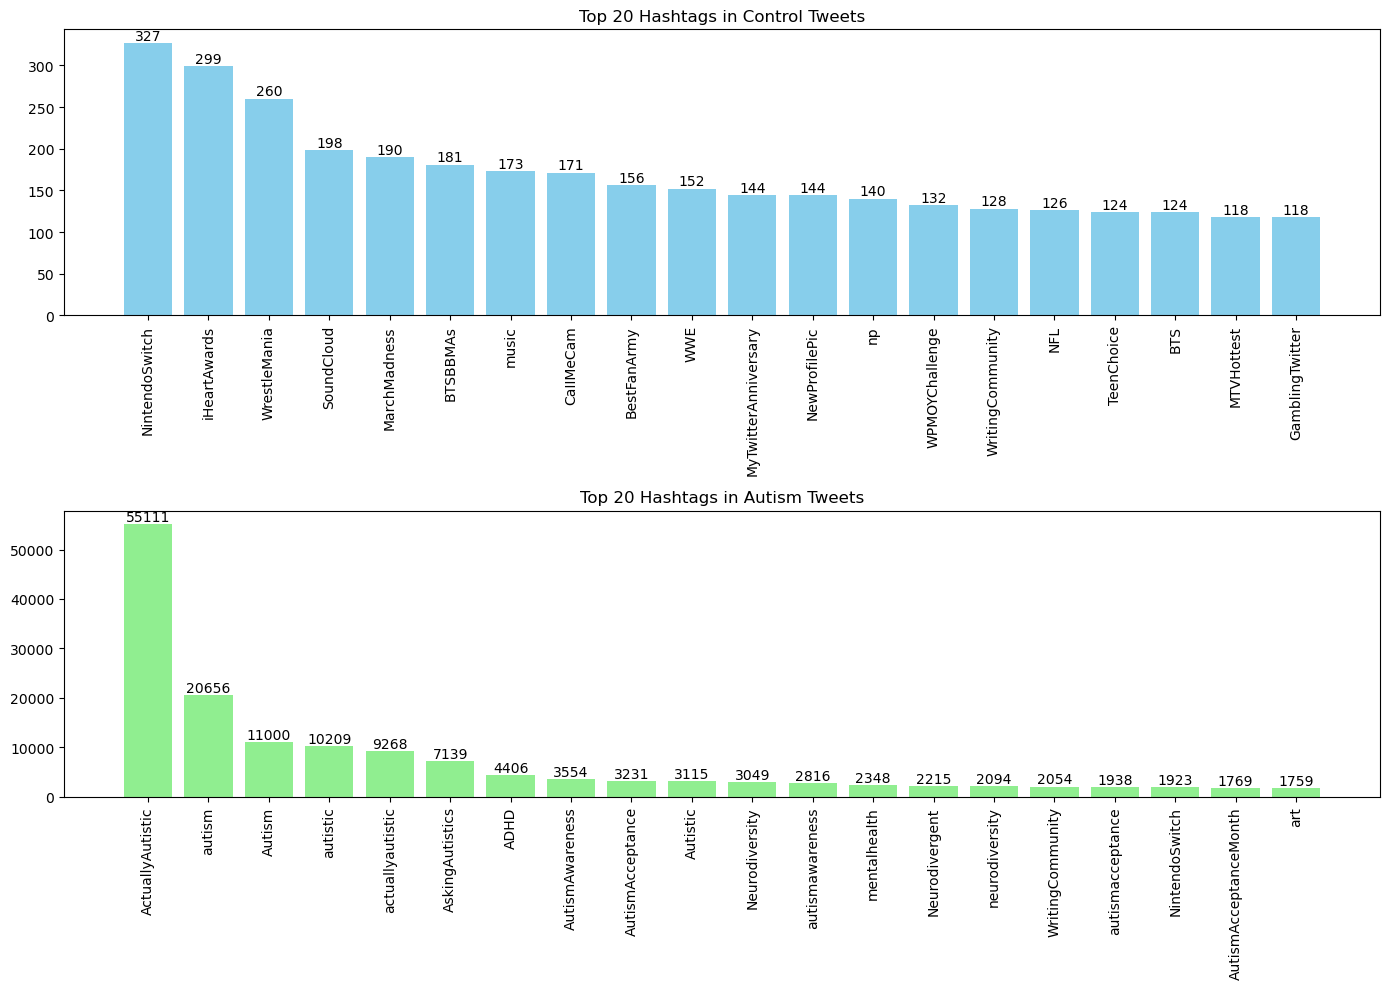

In [12]:
# Get the top 20 hashtags
top_20_control_hashtags = control_hashtag_freq.most_common(20)
top_20_autism_hashtags = autism_hashtag_freq.most_common(20)

# Plot the top 20 hashtags comparison
fig, axs = plt.subplots(2, 1, figsize=(14, 10))

control_hashtags_df = pd.DataFrame(
    top_20_control_hashtags, columns=['Hashtag', 'Count'])
autism_hashtags_df = pd.DataFrame(
    top_20_autism_hashtags, columns=['Hashtag', 'Count'])

# Plot for Control Tweets
axs[0].bar(control_hashtags_df.index,
           control_hashtags_df['Count'], color='skyblue')
axs[0].set_title('Top 20 Hashtags in Control Tweets')
axs[0].set_xticks(control_hashtags_df.index)
axs[0].set_xticklabels(control_hashtags_df['Hashtag'], rotation=90)
for i, v in enumerate(control_hashtags_df['Count']):
    axs[0].text(i, v + 0.5, str(v), ha='center', va='bottom')

# Plot for Autism Tweets
axs[1].bar(autism_hashtags_df.index,
           autism_hashtags_df['Count'], color='lightgreen')
axs[1].set_title('Top 20 Hashtags in Autism Tweets')
axs[1].set_xticks(autism_hashtags_df.index)
axs[1].set_xticklabels(autism_hashtags_df['Hashtag'], rotation=90)
for i, v in enumerate(autism_hashtags_df['Count']):
    axs[1].text(i, v + 0.5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### topic modelling on "Hashtags": add another column which store 1 for all strings are about autism; 0 for nothing about autism; 2 for both

In [13]:
# Define the list of autism-related hashtags
autism_related_hashtags = [
    'ActuallyAutistic', 'AskingAutistics', 'actuallyautistic', 'ADHD', 'autism', 'Neurodivergent', 'AuDHD', 'autistic', 'Autism', 
    'MentalHealth', 'AutisticTwitter','adhd', 'asd', 'aspie', 'MentalIllness', 'MentalHealthMatters','AutismAwareness', 'AutismAcceptance', 
    'autismawareness', 'Autistic','ASD', 'autismacceptance', 'Neurodivergent', 'aspergers', 'AllAutistics', 'neurodivergent',
    'DisabilityTwitter',  'depression','Aspergers', 'Disability',  'MentalHealthAwareness', 'autchat',
    'PTSD', 'neurodiversesquad', 'AutismAwarenessMonth', 'adhdtwitter', 'CPTSD', 'StopTheShock', 'Activate4Autism', 'awesomism'
]

# Function to determine the value of 'hashtag_top'
def determine_hashtag_top(hashtags):
    if not hashtags:
        return 0
    autism_tags = [tag for tag in hashtags if tag in autism_related_hashtags]
    if len(autism_tags) == len(hashtags):
        return 1
    elif len(autism_tags) == 0:
        return 0
    else:
        return 2


# Apply the function to create the 'hashtag_top' column
control_tweets_df['hashtag_top'] = control_tweets_df['Hashtags'].apply(
    determine_hashtag_top)
autism_tweets_df['hashtag_top'] = autism_tweets_df['Hashtags'].apply(
    determine_hashtag_top)

# Display the first few rows of the updated DataFrames
control_tweets_df.head(), autism_tweets_df.head()

(                                             User_ID  \
 0  f313e088777ce93cfb3c9e5e9aa6532d7f2c7197bc18b1...   
 1  a8ecfe6092e1115c42438cfed6cc79871d28699a40976c...   
 2  f4cc135a7544cc1243031a3bdb06392e5392222592fbfb...   
 3  c6231fc6a0ff4647907fe64eb3afb540f16418736eae66...   
 4  bad9f49c9ab505f6e56c931c2049c77889e4de026f95ee...   
 
                                  Profile description  Friends count  \
 0                                                NaN         1494.0   
 1  We build Latina/x power in New York to secure ...         1575.0   
 2  I PRAY FOR INCREASE 🙏🏿Jeremiah 29:11, living p...          135.0   
 3     @yassizzle @louyanong @itsdredesu @lenirobredo          161.0   
 4                                       Eric's Baby😻           58.0   
 
   Followers count                 Tweet date             Tweet id  \
 0             321  2016-01-24 23:59:56+00:00   691410136271708160   
 1            1231  2019-05-17 23:59:46+00:00  1129537022224424961   
 2          

# save the final files for network, user-interaction network

In [14]:
# Ensure counts are integers and handle NaNs
control_tweets_df['Reply count'] = control_tweets_df['Reply count'].fillna(0).astype(int)
control_tweets_df['Retweet count'] = control_tweets_df['Retweet count'].fillna(0).astype(int)
control_tweets_df['Like count'] = control_tweets_df['Like count'].fillna(0).astype(int)

autism_tweets_df['Reply count'] = autism_tweets_df['Reply count'].fillna(0).astype(int)
autism_tweets_df['Retweet count'] = autism_tweets_df['Retweet count'].fillna(0).astype(int)
autism_tweets_df['Like count'] = autism_tweets_df['Like count'].fillna(0).astype(int)

In [15]:
control_tweets_df.describe

<bound method NDFrame.describe of                                                  User_ID  \
0      f313e088777ce93cfb3c9e5e9aa6532d7f2c7197bc18b1...   
1      a8ecfe6092e1115c42438cfed6cc79871d28699a40976c...   
2      f4cc135a7544cc1243031a3bdb06392e5392222592fbfb...   
3      c6231fc6a0ff4647907fe64eb3afb540f16418736eae66...   
4      bad9f49c9ab505f6e56c931c2049c77889e4de026f95ee...   
...                                                  ...   
59864  779e32619786dd6f124d378f73995e217a8fe743f70865...   
59865  6fa9d6094467d9329a1ccc6583432847a0ebd8d0b8eada...   
59866  e1fe71d9de2a2470a597a69aa58d846e6a3fda0490e66b...   
59867  c0ccf7d6df8a85b3d6f410bbbfc1f4db0eb12075b0eeca...   
59868  6d3601b718731af3b0d0a667acb6672e85a35b62a34310...   

                                     Profile description  Friends count  \
0                                                    NaN         1494.0   
1      We build Latina/x power in New York to secure ...         1575.0   
2      I PRAY FOR IN

In [17]:
# Select relevant columns
columns = ['User_ID', 'Tweet id', 'Tweet date', 'Retweet count', 'Tweet text', 
           'Reply count', 'Tweet Text Sentiment', 'hashtag_top', 'Like count']

control_user_df = control_tweets_df[columns]
autism_user_df = autism_tweets_df[columns]

# Filter rows to keep only those with 'Tweet id' appearing multiple times
control_user_df = control_user_df[control_user_df['Retweet count'] > 0]
autism_user_df = autism_user_df[autism_user_df['Retweet count'] > 0]

In [18]:
print("New total number of rows:", control_user_df.shape[0])
print("New total number of rows:", autism_user_df.shape[0])

New total number of rows: 41157
New total number of rows: 189664


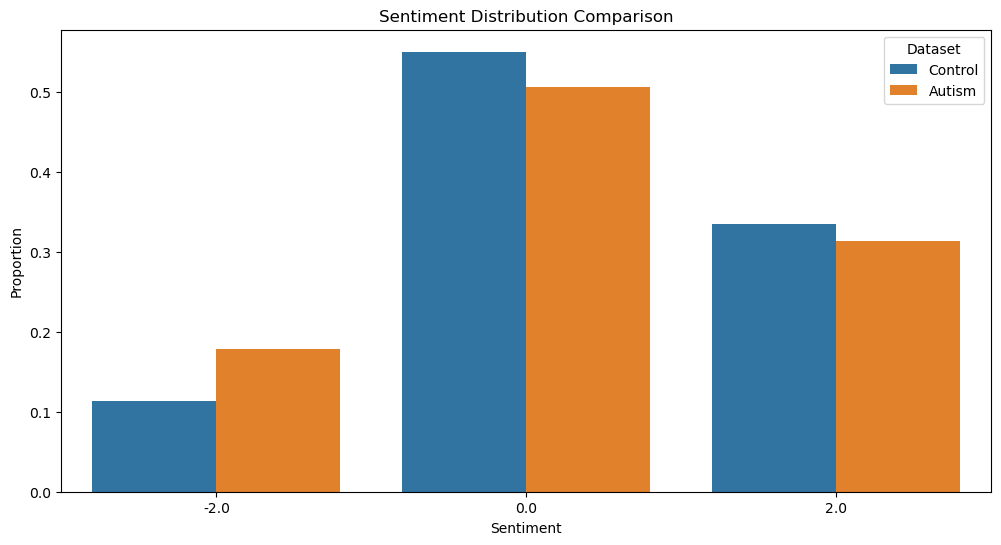

Chi-Square Test Results:
Chi2 Statistic: 3.7218327913723703
P-value: 0.4449584356974774
There is no significant difference in the sentiment distributions between the two groups.


In [19]:
# Extract sentiment distributions
control_sentiment_dist = control_tweets_df['Tweet Text Sentiment'].value_counts(
    normalize=True)
autism_sentiment_dist = autism_tweets_df['Tweet Text Sentiment'].value_counts(
    normalize=True)

# Combine sentiment distributions into a DataFrame for visualization
sentiment_dist_df = pd.DataFrame({
    'Sentiment': control_sentiment_dist.index,
    'Control': control_sentiment_dist.values,
    'Autism': autism_sentiment_dist.reindex(control_sentiment_dist.index).fillna(0).values
}).melt(id_vars='Sentiment', var_name='Dataset', value_name='Proportion')

# Visualize sentiment distributions
plt.figure(figsize=(12, 6))
sns.barplot(x='Sentiment', y='Proportion',
            hue='Dataset', data=sentiment_dist_df)
plt.title('Sentiment Distribution Comparison')
plt.xlabel('Sentiment')
plt.ylabel('Proportion')
plt.show()

# Statistical test: Chi-Square test of independence
contingency_table = pd.crosstab(
    control_tweets_df['Tweet Text Sentiment'], autism_tweets_df['Tweet Text Sentiment'])
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(f"Chi-Square Test Results:\nChi2 Statistic: {chi2}\nP-value: {p}")

# Interpretation based on p-value
if p < 0.05:
    print("The sentiment distributions between the two groups are significantly different.")
else:
    print("There is no significant difference in the sentiment distributions between the two groups.")

In [20]:
# Save the filtered data to new CSV files
filtered_control_user_file = '/Users/xuenichen/Desktop/BEF_Chen/dataset/control_user-.csv'
filtered_autism_user_file = '/Users/xuenichen/Desktop/BEF_Chen/dataset/autism_user-.csv'

control_user_df.to_csv(filtered_control_user_file, index=False)
autism_user_df.to_csv(filtered_autism_user_file, index=False)

print(f"Filtered control user data saved to {filtered_control_user_file}")
print(f"Filtered autism user data saved to {filtered_autism_user_file}")

Filtered control user data saved to /Users/xuenichen/Desktop/BEF_Chen/dataset/control_user-.csv
Filtered autism user data saved to /Users/xuenichen/Desktop/BEF_Chen/dataset/autism_user-.csv
